# Exploring the Demographics of COVID-19 Cases 

----------------------
### Data Source: [Kaggle's Novel Corona Virus 2019 Dataset (Day level information on covid-19 affected cases)](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset)

#### Fan Wang 
#### March 31

In this notebook, we explore some of the demographic data associated with COVID-19 cases in a Gen3 Data Commons. Specifically, we focus
on the individual-level dataset from [Kaggle](https://www.kaggle.com/sudalairajkumar/novel-corona-virus-2019-dataset) stratified by
age and gender. All results shown in this notebook are for demonstration purposes and should not be considered scientifically rigorous.

## Setup

### Install dependecies (if needed)

In [ ]:
!pip install --force --upgrade gen3 --ignore-installed certifi
!pip install numpy
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install pywaffle

### Import libraries

In [3]:
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import re
import gen3

from pandas import DataFrame
from pywaffle import Waffle
from gen3.auth import Gen3Auth
from gen3.submission import Gen3Submission


warnings.filterwarnings("ignore")
sns.set(style="ticks", color_codes=True)
%config InlineBackend.figure_format = 'svg'
%matplotlib inline

### Use Gen3 SDK to extract demographic data

To extract the data we need, we simply export the `demographic` and `subject` nodes from a Gen3 Data Commons.

In [7]:
# Setup gen3
api = "https://covid19.datacommons.io/"
creds = "/home/jovyan/pd/credentials.json"
auth = Gen3Auth(api, creds)
sub = Gen3Submission(api, auth)

# Query parameters
program = "open"
project = "nCoV2019"

# Export subject nodes
subject_data = sub.export_node(program, project, "subject", "tsv", "subject.tsv")

# Export demographic nodes
demographic_data = sub.export_node(
    program, project, "demographic", "tsv", "demographic.tsv"
)


Output written to file: subject.tsv

Output written to file: demographic.tsv


### Merge the exported files

In [4]:
# Load the subject and demographic data
subject = pd.read_csv("/home/jovyan/pd/subject.tsv", sep="\t")
subject = subject.rename(columns={"submitter_id": "subjects.submitter_id"})
demographic = pd.read_csv("/home/jovyan/pd/demographic.tsv", sep="\t")

# Merge the two dataframes to simplify analysis
merge = pd.merge(subject, demographic, on="subjects.submitter_id", how="inner")
covid = merge[["subjects.submitter_id", "age", "sex"]]
covid = covid.replace("None", np.nan)
# Dropping the NaN in age.
covid = covid.dropna(subset=["age"])
covid["age"] = covid["age"].astype(float)

### Make new column `age_group` for binned ages

In [5]:
covid.loc[(covid["age"] < 10), "age_group"] = "0-9"
covid.loc[(covid["age"] < 20) & (covid["age"] >= 10), "age_group"] = "10-19"
covid.loc[(covid["age"] < 30) & (covid["age"] >= 20), "age_group"] = "20-29"
covid.loc[(covid["age"] < 40) & (covid["age"] >= 30), "age_group"] = "30-39"
covid.loc[(covid["age"] < 50) & (covid["age"] >= 40), "age_group"] = "40-49"
covid.loc[(covid["age"] < 60) & (covid["age"] >= 50), "age_group"] = "50-59"
covid.loc[(covid["age"] < 70) & (covid["age"] >= 60), "age_group"] = "60-69"
covid.loc[(covid["age"] < 80) & (covid["age"] >= 70), "age_group"] = "70-79"
covid.loc[(covid["age"] >= 80), "age_group"] = "80+"

In [6]:
covid = covid.replace("male", "Male")
covid = covid.replace("female", "Female")

## 1. Breakdown of Positive Cases by Gender

In [7]:
# Get frequency of Male/Female
sex_count = covid.pivot_table(index=["sex"], aggfunc="size")
print(sex_count)

sex
Female    349
Male      476
dtype: int64


### Pie Chart

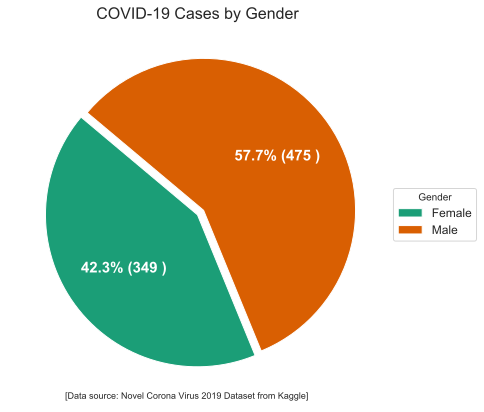

In [8]:
def func(pct, allvals):
    """Helper function to format percentages
    
    Args:
        pct: Percentage float value
        allvals: dataframe of counts
        
    Returns:
        Formatted string
    """
    absolute = int(pct / 100.0 * np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

# Setup data
df = covid.groupby("sex").size().reset_index(name="counts")
data = df["counts"]
categories = df["sex"]
explode = [0, 0.05]

# Generate plot
fig, ax = plt.subplots(figsize=(12, 7), subplot_kw=dict(aspect="equal"), dpi=200)
wedges, texts, autotexts = ax.pie(
    data,
    autopct=lambda pct: func(pct, data),
    textprops=dict(color="w"),
    colors=plt.cm.Dark2.colors,
    startangle=140,
    explode=explode,
)

ax.legend(
    wedges,
    categories,
    title="Gender",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1),
    fontsize=12,
)
plt.setp(autotexts, size=15, weight=700)
ax.set_title("COVID-19 Cases by Gender", fontdict={"size": 16})
plt.suptitle(
    "[Data source: Novel Corona Virus 2019 Dataset from Kaggle]", fontsize=9, y=0.15
)
plt.show()

#### Figure 1.  Gender composition of the total confirmed cases (Female = 349, Male = 476).

### Waffle Plot

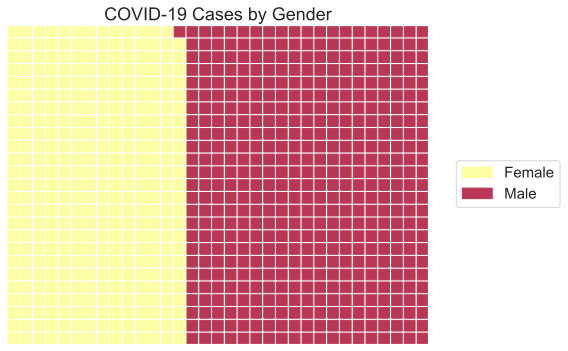

In [9]:
# Setup data
df = covid.groupby("sex").size().reset_index(name="counts")
n_categories = df.shape[0]
colors = [plt.cm.inferno_r(i / float(n_categories)) for i in range(n_categories)]

# Draw Plot and Decorate
fig = plt.figure(
    FigureClass=Waffle,
    plots={
        "111": {
            "values": df["counts"],
            "labels": ["{}".format(n[1]) for n in df[["sex", "counts"]].itertuples()],
            "legend": {
                "loc": "upper left",
                "bbox_to_anchor": (1.05, 0.6),
                "fontsize": 15,
            },
            "title": {
                "label": "COVID-19 Cases by Gender",
                "loc": "center",
                "fontsize": 18,
            },
        },
    },
    rows=25,
    colors=colors,
    figsize=(8, 6),
)

#### Figure 2.  Gender composition of the total confirmed cases (Female = 349, Male = 476).

## 2. Breakdown of Positive Cases by Age Group

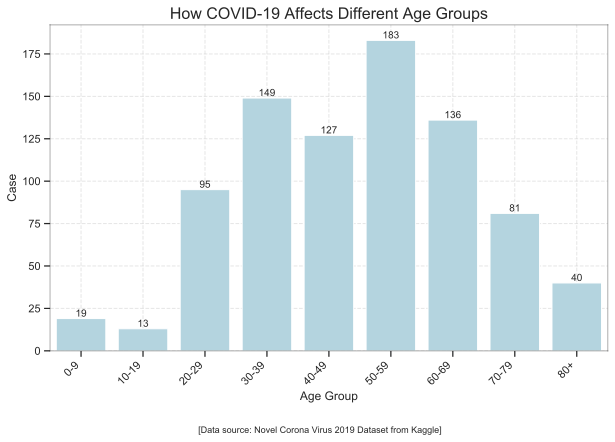

In [10]:
# Setup data
df = covid.groupby("age_group").size().reset_index(name="counts")
n = df["age_group"].unique().__len__() + 1

# Setup plot
plt.figure(figsize=(10, 6), dpi=300)
order = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
sns.countplot(x="age_group", order=order, data=covid, color="lightblue")
plt.suptitle(
    "[Data source: Novel Corona Virus 2019 Dataset from Kaggle]", fontsize=9, y=-0.05
)
plt.title("How COVID-19 Affects Different Age Groups", fontdict={"size": 16})
plt.grid(linestyle="--", alpha=0.5)
plt.gca().set_xticklabels(order, rotation=45, horizontalalignment="right")
plt.gca().spines["top"].set_alpha(0.3)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)
plt.gca().spines["left"].set_alpha(0.3)
plt.xlabel("Age Group")
plt.ylabel("Case")

all_colors = list(plt.cm.colors.cnames.keys())

# Make subplots
for i, val in enumerate(df["counts"].values):
    plt.text(
        i,
        val,
        int(val),
        horizontalalignment="center",
        verticalalignment="bottom",
        fontdict={"fontweight": 500, "size": 10},
    )
plt.show()

#### Figure 3.  The number of confirmed cases by age group.

## 3. Breakdown of Positive Cases by Gender and Age Group

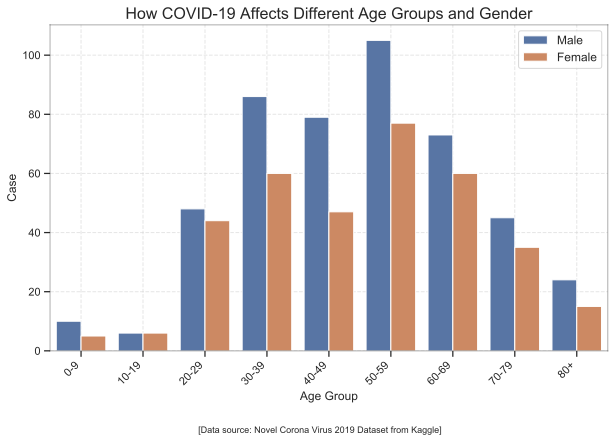

In [11]:
plt.figure(figsize=(10, 6), dpi=300)
order = ["0-9", "10-19", "20-29", "30-39", "40-49", "50-59", "60-69", "70-79", "80+"]
sns.countplot(x="age_group", hue="sex", order=order, data=covid)
plt.title("How COVID-19 Affects Different Age Groups and Gender", fontdict={"size": 16})
plt.suptitle(
    "[Data source: Novel Corona Virus 2019 Dataset from Kaggle]", fontsize=9, y=-0.05
)
plt.grid(linestyle="--", alpha=0.5)
plt.legend(fontsize=12)
plt.gca().set_xticklabels(order, rotation=45, horizontalalignment="right")
plt.gca().spines["top"].set_alpha(0.3)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)
plt.gca().spines["left"].set_alpha(0.3)
plt.xlabel("Age Group")
plt.ylabel("Case")
plt.show()

#### Figure 4.  The number of confirmed cases by age group and gender.

## 4. Statistical Summary

### Skewness and Kurtosis

In [14]:
from scipy import stats

male = covid[covid.sex == "Male"]
female = covid[covid.sex == "Female"]

print(stats.describe(male["age"]))
print(stats.describe(female["age"]))

DescribeResult(nobs=476, minmax=(0.5, 89.0), mean=49.84768907563025, variance=320.00043675364884, skewness=-0.09816514699379916, kurtosis=-0.40217335054349146)
DescribeResult(nobs=349, minmax=(2.0, 89.0), mean=49.60458452722063, variance=327.48112834700134, skewness=-0.11667697027245859, kurtosis=-0.6142827935635085)


### T-test on Age

In [15]:
stats.ttest_ind(male["age"], female["age"])

Ttest_indResult(statistic=0.1918982805799698, pvalue=0.8478692204149347)

#### Since the p-value is larger than 0.05, we cannot conclude that significant difference exists between age difference affected by COVID-19.


### Confidence Interval

In [16]:
def calculate_95_ci(array_1, array_2):
    """Estimates the 95% confidence interval.
    
    Args:
        array_1: Array of values for group 1
        array_2: Array of values for group 2
        
    Returns:
        Tuple of text, lower CI, and upper CI
    """
    sample_1_n = array_1.shape[0]
    sample_2_n = array_2.shape[0]
    sample_1_mean = array_1.mean()
    sample_2_mean = array_2.mean()
    sample_1_var = array_1.var()
    sample_2_var = array_2.var()
    mean_difference = sample_2_mean - sample_1_mean
    std_err_difference = math.sqrt(
        (sample_1_var / sample_1_n) + (sample_2_var / sample_2_n)
    )
    margin_of_error = 1.96 * std_err_difference
    ci_lower = mean_difference - margin_of_error
    ci_upper = mean_difference + margin_of_error
    return (
        "The difference in means at the 95% confidence interval (two-tail) is between "
        + str(ci_lower)
        + " and "
        + str(ci_upper)
        + "."
    )

calculate_95_ci(male["age"], female["age"])

'The difference in means at the 95% confidence interval (two-tail) is between -2.730537735343311 and 2.2443286385240735.'

### Violin Plot for Gender and Age

COVID-19 male cases are a little younger than female cases.

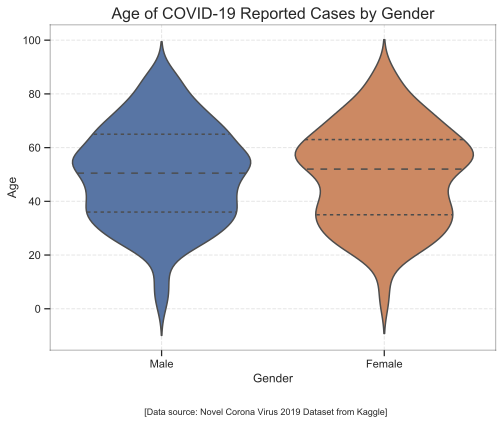

In [17]:
plt.figure(figsize=(8, 6), dpi=200)
sns.violinplot(x="sex", y="age", data=covid, scale="width", inner="quartile")
plt.ylabel("Age")
plt.xlabel("Gender")
plt.grid(linestyle="--", alpha=0.5)
plt.gca().spines["top"].set_alpha(0.3)
plt.gca().spines["bottom"].set_alpha(0.3)
plt.gca().spines["right"].set_alpha(0.3)
plt.gca().spines["left"].set_alpha(0.3)
plt.title("Age of COVID-19 Reported Cases by Gender", fontsize=16)
plt.suptitle(
    "[Data source: Novel Corona Virus 2019 Dataset from Kaggle]", fontsize=9, y=-0.01
)
plt.show()

#### Figure 5.  The age variation between males and females infected population.

## Summary

This notebook showcases some of the data in a Gen3 Data Commons and the ability to
do exploratory analysis. Many of the datasets are updated daily and new data can be included by simply
re-running the notebook.